<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Things-to-Consider" data-toc-modified-id="Things-to-Consider-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Things to Consider</a></span></li><li><span><a href="#Synthetic-Input" data-toc-modified-id="Synthetic-Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Synthetic Input</a></span></li><li><span><a href="#Fully-Connected-Neural-Network-With-Linear-Output" data-toc-modified-id="Fully-Connected-Neural-Network-With-Linear-Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fully-Connected Neural Network With Linear Output</a></span></li><li><span><a href="#Training-Loop" data-toc-modified-id="Training-Loop-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training Loop</a></span></li><li><span><a href="#Examine-Hidden-Calculations" data-toc-modified-id="Examine-Hidden-Calculations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Examine Hidden Calculations</a></span><ul class="toc-item"><li><span><a href="#What-do-the-outputs-of-each-of-the-eight-hidden-layer-neurons-look-like?" data-toc-modified-id="What-do-the-outputs-of-each-of-the-eight-hidden-layer-neurons-look-like?-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>What do the outputs of each of the eight hidden layer neurons look like?</a></span></li></ul></li><li><span><a href="#Model-Initialization-and-Normalization" data-toc-modified-id="Model-Initialization-and-Normalization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model Initialization and Normalization</a></span></li></ul></div>

## Things to Consider

1. The purpose of activation functions.
1. The benefits of with and depth.
1. Causes of problematic gradients (vanishing and exploding).
1. Proper parameter initialization.
1. Normalization (input and between layers).

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

from fastprogress.fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

## Synthetic Input

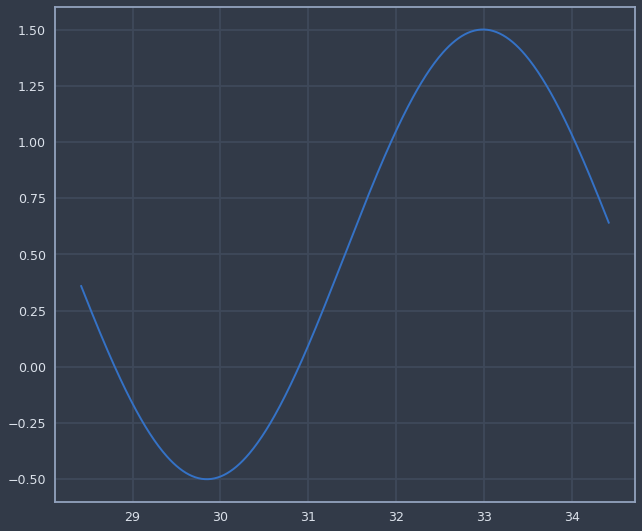

In [78]:
N = 500
X = torch.linspace(-3, 3, N).reshape(-1, 1) + 3.1415926 * 10
y = torch.sin(X) + 0.5
_ = plt.plot(X, y)

## Fully-Connected Neural Network With Linear Output

In [79]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()

        # Hidden layers
        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU())
#             nn.Sequential(nn.Linear(nlminus1, nl))
#             nn.Sequential(nn.Linear(nlminus1, nl), nn.Sigmoid())
#             nn.Sequential(nn.Linear(nlminus1, nl), nn.LeakyReLU())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # Output layer
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])
#         output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1], bias=True)
        
        # Group all layers into the sequential container
        all_layers = hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

## Training Loop

In [80]:
def train(model, X, y, num_epochs=2000):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()

    losses = []

    for epoch in progress_bar(range(num_epochs)):
        yhat = model(X)
        loss = criterion(yhat, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses


# Compare: width vs depth
# layer_sizes = (1, 100, 1)  # "wider"
# layer_sizes = (1, 100, 100, 100, 100, 100, 5, 1)  # "deeper"
layer_sizes = (1, 8, 1)

# Universal approximation theorem: a two-layer network can approximate any function
# - it takes O(2^n) exponential width
# - to have the same complexity as a polynomial deep network

model = NeuralNetwork(layer_sizes)
summary(model)
losses = train(model, X, y)
print(f"Final loss: {losses[-1]:.6f}")

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  16
|    |    └─ReLU: 3-2                    --
|    └─Linear: 2-2                       9
Total params: 25
Trainable params: 25
Non-trainable params: 0


Final loss: 0.435365


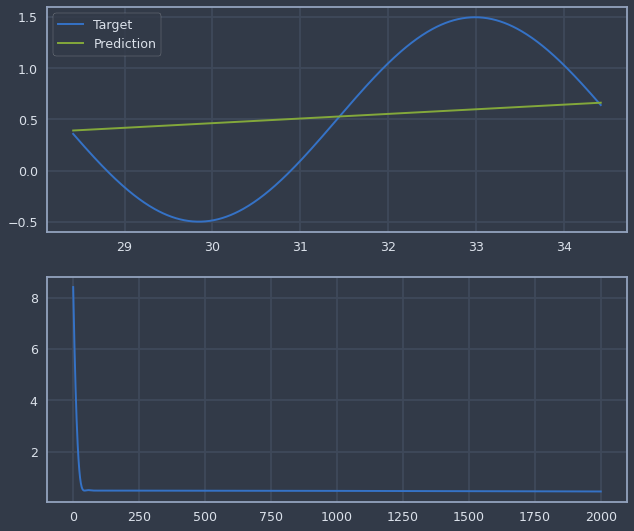

In [81]:
yhat = model(X)

_, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(X, y, label="Target")
ax1.plot(X, yhat.detach(), label="Prediction")
ax1.legend()
_ = ax2.plot(losses)

## Examine Hidden Calculations

### What do the outputs of each of the eight hidden layer neurons look like?

In [82]:
final_layer_input = None


def capture_final_outputs(module, layer_in, layer_out) -> None:
    global final_layer_input
    final_layer_input = layer_in[0].detach()

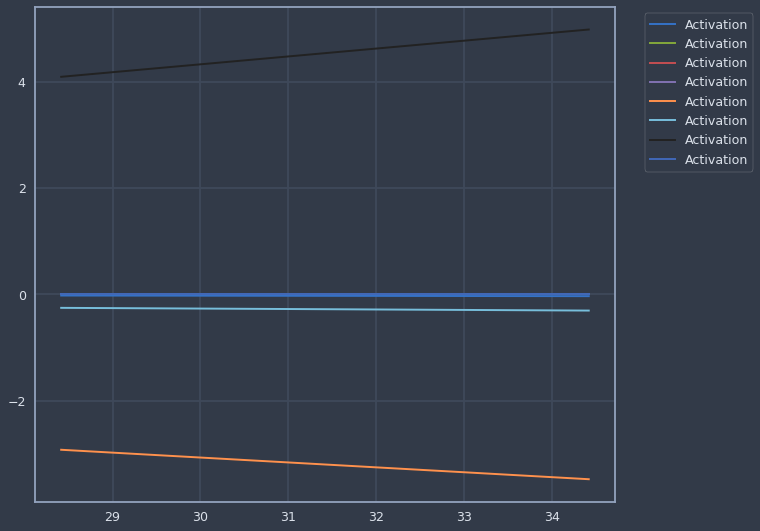

In [83]:
# Register hook to capture input to final layer (if not already registered)
if final_layer_input == None:
    final_layer = model.layers[-1]
    final_layer.register_forward_hook(capture_final_outputs)

# Compute model output and capture input to final layer
# X = torch.linspace(10, 20, 100).reshape(-1, 1)
yhat = model(X)

# Grab parameters for the output layer
WL = list(model.parameters())[-2].detach()
bL = list(model.parameters())[-1].item()

# Plot each input to the final layer
plt.plot(X, final_layer_input * WL, label="Activation")

# # Plot the output of the final layer
# plt.plot(X, yhat.detach(), "o", label="yhat")

# # Compare with hand-computed final layer output
# plt.plot(X, final_layer_input @ WL.T + bL, "--", label="Combined Activations")

_ = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## Model Initialization and Normalization

In [ ]:
def init_weights(layer):
    if type(layer) == torch.nn.Linear:
        print("Initializing", layer)

        if kind == "zeros":
            layer.weight.data.fill_(0.0)
            layer.bias.data.fill_(0.0)

        elif kind == "ones":
            layer.weight.data.fill_(1.0)
            layer.bias.data.fill_(1.0)

        elif kind == "uniform":
            layer.weight.data.uniform_()
            layer.bias.data.fill_(0.0)

        elif kind == "normal":
            layer.weight.data.normal_()
            layer.bias.data.fill_(0.0)

        elif kind == "normal2":
            layer.weight.data.normal_() * (1 / torch.sqrt(torch.tensor(layer.weight.shape[0])))
            layer.bias.data.fill_(0.0)

        elif kind == "xavier":
            torch.nn.init.xavier_uniform_(layer.weight)

        elif kind == "kaiming":
            torch.nn.init.kaiming_normal_(layer.weight)

        else:
            print(f"'{kind}' is not handled")


layer_sizes = (1, 10, 10, 10, 1)

model = NeuralNetwork(layer_sizes)
kind = "zeros"
model.apply(init_weights)

losses = train(model, X, y)
print(f"Final loss: {losses[-1]:.3f}")

with torch.no_grad():
    A = X
    std, mean = torch.std_mean(A)
    print(f"\n*** A0: Mean = {mean.item():.3f}, STD = {std.item():.3f}\n")
    for l, layer in enumerate(model.layers):
        print(layer)
        A = layer(A)
        std, mean = torch.std_mean(A)
        print(f"\n*** A{l+1}: Mean = {mean.item():.3f}, STD = {std.item():.3f}\n")